In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pickle as pkl
import os
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load MNIST
(mnist_X, mnist_y), (mnist_X_, mnist_y_)= tf.keras.datasets.mnist.load_data()

mnist_X = np.reshape(mnist_X,(60000, 28, 28, 1)) / 255
mnist_X = np.tile(mnist_X, (1, 1, 1, 3))
mnist_X = mnist_X.astype('float32')
print(mnist_X.shape)

mnist_X_ = np.reshape(mnist_X_,(10000, 28, 28, 1)) / 255
mnist_X_ = np.tile(mnist_X_, (1, 1, 1, 3))
mnist_X_ = mnist_X_.astype('float32')
print(mnist_X_.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


In [3]:
# Load USPS
with h5py.File('usps.h5', 'r') as hf:
    usps_train = hf.get('train')
    usps_X = usps_train.get('data')[:]
    usps_y = usps_train.get('target')[:]
    usps_test = hf.get('test')
    usps_X_ = usps_test.get('data')[:]
    usps_y_ = usps_test.get('target')[:]

padding = [[0, 0],
           [6, 6],
           [6, 6],
           [0, 0]]

usps_X = np.reshape(usps_X, (-1, 16, 16, 1))
usps_X = np.tile(usps_X, (1,1,1,3))
usps_X = tf.pad(usps_X, padding, 'CONSTANT').numpy()
print(usps_X.shape)

usps_X_ = np.reshape(usps_X_, (-1, 16, 16, 1))
usps_X_ = np.tile(usps_X_, (1,1,1,3))
usps_X_ = tf.pad(usps_X_, padding, 'CONSTANT').numpy()
print(usps_X_.shape)

(7291, 28, 28, 3)
(2007, 28, 28, 3)


In [4]:
# Load MNIST-M
mnistm = pkl.load(open('mnistm.pkl', 'rb'))
mnistm_X = mnistm['train'] / 255
mnistm_X = mnistm_X.astype('float32')
mnistm_X_ = mnistm['test'] / 255
mnistm_X_ = mnistm_X_.astype('float32')

MNIST SAMPLE: 3
USPS SAMPLE: 7
USPS SAMPLE: 3


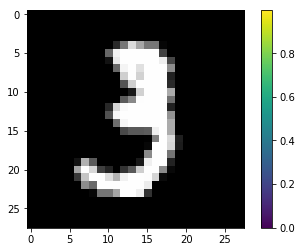

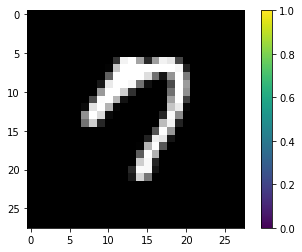

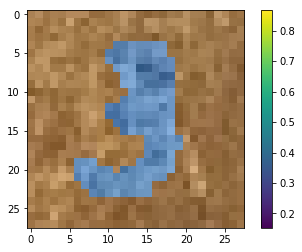

In [5]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()

print("MNIST SAMPLE: {}".format(mnist_y[10]))
show_img(mnist_X[10])
print("USPS SAMPLE: {}".format(usps_y[10]))
show_img(usps_X[10])
print("USPS SAMPLE: {}".format(mnist_y[10]))
show_img(mnistm_X[10])

### Dataset Details

 - For adaptation between MNIST and USPS, we follow the training protocol established in [21], __sampling 2000 images from MNIST and 1800 from USPS.__

### Model Details

 - our adversarial discriminator consists of 3 fully connected layers: two layers with 500 hidden units followed by the final discriminator output
 - Each of the 500-unit layers uses a ReLU activation function

In [6]:
def LeNetEncoder():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(20, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(50, (5, 5),
                        activation='relu',
                        input_shape=(28, 28, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(500,
                           activation='relu'))
    
    return model

In [7]:
def LeNetClassifier():
    model = tf.keras.Sequential()
    model.add(layers.Dropout(0.1,
                             input_shape=(500,)))
    model.add(layers.Dense(10,
                           activation='softmax'))
    
    return model

In [8]:
def Critics():
    model = tf.keras.Sequential()
    model.add(layers.Dense(500,
                           input_shape=(500,),
                           activation='relu'))
    model.add(layers.Dense(500,
                           activation='relu'))
    model.add(layers.Dense(2,
                           activation='softmax'))
    
    return model

In [9]:
source_encoder = LeNetEncoder()
target_encoder = LeNetEncoder()
source_classifier = LeNetClassifier()

In [10]:
mnist_train_set = tf.data.Dataset.from_tensor_slices((mnist_X, mnist_y)).shuffle(buffer_size=mnist_X.shape[0]).batch(64)
mnist_test_set = tf.data.Dataset.from_tensor_slices((mnist_X_, mnist_y_)).shuffle(buffer_size=mnist_X_.shape[0]).batch(64)
usps_train_set = tf.data.Dataset.from_tensor_slices((usps_X, usps_y)).shuffle(buffer_size=usps_X.shape[0]).batch(64)
usps_test_set = tf.data.Dataset.from_tensor_slices((usps_X_, usps_y_)).shuffle(buffer_size=usps_X_.shape[0]).batch(64)
mnistm_train_set = tf.data.Dataset.from_tensor_slices((mnistm_X, mnist_y)).shuffle(buffer_size=mnist_X.shape[0]).batch(64)
mnistm_test_set = tf.data.Dataset.from_tensor_slices((mnistm_X_, mnist_y_)).shuffle(buffer_size=mnist_X_.shape[0]).batch(64)

In [11]:
# pre-train (1) source_encoder, (2) source_classifier
@tf.function
def pretrain_step(X, y):
    with tf.GradientTape() as tape:
        embedding = source_encoder(X)
        pred = source_classifier(embedding)
        loss_value = loss(y, pred)
        
    tvars = source_encoder.trainable_variables + source_classifier.trainable_variables
    grads = tape.gradient(loss_value, tvars)
    opt.apply_gradients(zip(grads, tvars))
    
    return pred, loss_value

In [12]:
loss = keras.losses.SparseCategoricalCrossentropy()

In [33]:
def model_eval(mydata, encoder, verbose=True):
    avg = keras.metrics.Mean()
    accuracy = keras.metrics.SparseCategoricalAccuracy()
    for X, y in mydata:
        # inference
        ebd = encoder(X)
        prob = source_classifier(ebd)
        lv = loss(y, prob)

        # results
        avg(lv)
        accuracy(y, prob)
    
    loss_v = avg.result().numpy()
    accuracy_v = accuracy.result().numpy()
    
    if verbose:
        print("Loss: {:.4}".format(loss_v), end=" | ")
        print("Accuracy: {:.2%}".format(accuracy_v))
    
    return loss_v, accuracy_v

In [31]:
def pre_train(mydata, epoch, lr):
    learning_rate = lr
    
    for epoch in range(5):
        for X, y in mydata:
            pred, lv = pretrain_step(X, y)
            pred_idx = tf.argmax(pred, axis=1)
            
            learning_rate = learning_rate / (1 + epoch/10)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)

        l, a = model_eval(mnist_test_set, source_encoder, False)
        print("Epoch:{}, Loss:{:.4}, Accuracy:{:.4}"
              .format(epoch,l,a))

In [34]:
pre_train(mnist_train_set, 5, 0.01)

Epoch:0, Loss:0.1431, Accuracy:0.9729
Epoch:1, Loss:0.1197, Accuracy:0.9787
Epoch:2, Loss:0.1386, Accuracy:0.9719
Epoch:3, Loss:0.1812, Accuracy:0.9697
Epoch:4, Loss:0.1254, Accuracy:0.9728


In [35]:
# Check Source Only Performance
print("MNIST TEST: ", end=' ')
model_eval(mnist_test_set, source_encoder)
print("USPS TEST: ", end=' ')
model_eval(usps_test_set, source_encoder)
print("MNISTM TEST: ", end=' ')
model_eval(mnistm_test_set, source_encoder)

MNIST TEST:  Loss: 0.1254 | Accuracy: 97.28%
USPS TEST:  Loss: 0.7081 | Accuracy: 84.30%
MNISTM TEST:  Loss: 11.96 | Accuracy: 16.03%


(11.964923, 0.1603)

In [36]:
source_encoder.save('mnist_train.h5')
target_encoder = keras.models.load_model('mnist_train.h5')
# source_encoder = keras.models.load_model('mnist_train.h5')

W1209 22:45:47.757917 139908610459392 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [37]:
# Check Model Load
model_eval(mnist_test_set, source_encoder)
model_eval(mnist_test_set, target_encoder)

Loss: 0.1254 | Accuracy: 97.28%
Loss: 0.1254 | Accuracy: 97.28%


(0.12539873, 0.9728)

In [39]:
critic = Critics()
cce = tf.keras.losses.SparseCategoricalCrossentropy()

In [46]:
@tf.function
def train_step(img_src, img_tgt):
    # discriminator
    with tf.GradientTape() as disc_tape:
        source_ebd = source_encoder(img_src, training=False)
        target_ebd = target_encoder(img_tgt, training=True)
        concat_ebd = tf.concat([source_ebd, target_ebd], 0)

        concat_pred = critic(concat_ebd, training=True)
        
        source_label = tf.ones_like(source_ebd[:, 0])
        target_label = tf.zeros_like(target_ebd[:, 0])
        concat_label = tf.concat([source_label, target_label], 0)
        
        disc_loss = cce(concat_label, concat_pred)

    disc_grads = disc_tape.gradient(disc_loss, critic.trainable_variables)
    disc_opt.apply_gradients(zip(disc_grads, critic.trainable_variables))
    
    with tf.GradientTape() as tgt_tape:
        target_ebd = target_encoder(img_tgt, training=True)
        target_pred = critic(target_ebd, training=False)
        target_label = tf.ones_like(target_pred[:, 0])
        
        target_loss = cce(target_label, target_pred)
        
    target_grads = tgt_tape.gradient(target_loss, target_encoder.trainable_variables)
    tgt_opt.apply_gradients(zip(target_grads, target_encoder.trainable_variables))
    
    return disc_loss, target_loss

In [47]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

dll = []
tll = []

In [48]:
lr = 1e-4
disc_opt = keras.optimizers.Adam(lr)
tgt_opt = keras.optimizers.Adam(lr)

for epoch in range(100):
    for (sx, sy), (tx, ty) in zip(mnist_train_set, mnistm_train_set):
        dl, tl = train_step(sx, tx)
        dll.append(dl.numpy())
        tll.append(tl.numpy())
        
    if (epoch + 1) % 10 == 0:
        lr = lr / 2
        disc_opt = keras.optimizers.Adam(lr)
        tgt_opt = keras.optimizers.Adam(lr)

        checkpoint = tf.train.Checkpoint(target_optimizer=tgt_opt,
                                         discriminator_optimizer=disc_opt,
                                         source_encoder=source_encoder,
                                         target_encoder=target_encoder,
                                         source_classifier=source_classifier,
                                         ciritic=critic)
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print("Epoch:"+str(epoch), end=" => ")
    model_eval(mnistm_test_set, target_encoder)    

Epoch:0 => Loss: 3.621 | Accuracy: 37.59%
Epoch:1 => Loss: 3.696 | Accuracy: 39.74%
Epoch:2 => Loss: 3.697 | Accuracy: 41.15%
Epoch:3 => Loss: 3.841 | Accuracy: 41.78%
Epoch:4 => Loss: 4.012 | Accuracy: 42.15%
Epoch:5 => Loss: 4.073 | Accuracy: 42.61%
Epoch:6 => Loss: 4.071 | Accuracy: 42.45%
Epoch:7 => Loss: 4.14 | Accuracy: 42.56%
Epoch:8 => Loss: 4.151 | Accuracy: 42.96%
Epoch:9 => Loss: 4.358 | Accuracy: 42.61%
Epoch:10 => Loss: 4.319 | Accuracy: 43.17%
Epoch:11 => Loss: 4.439 | Accuracy: 42.78%
Epoch:12 => Loss: 4.467 | Accuracy: 42.91%
Epoch:13 => Loss: 4.584 | Accuracy: 42.35%
Epoch:14 => Loss: 4.574 | Accuracy: 42.92%
Epoch:15 => Loss: 4.649 | Accuracy: 42.71%
Epoch:16 => Loss: 4.777 | Accuracy: 42.49%
Epoch:17 => Loss: 4.848 | Accuracy: 42.64%
Epoch:18 => Loss: 4.89 | Accuracy: 42.90%
Epoch:19 => Loss: 4.839 | Accuracy: 43.06%
Epoch:20 => Loss: 4.898 | Accuracy: 42.99%
Epoch:21 => Loss: 4.9 | Accuracy: 43.00%
Epoch:22 => Loss: 4.956 | Accuracy: 43.24%
Epoch:23 => Loss: 4.918 |

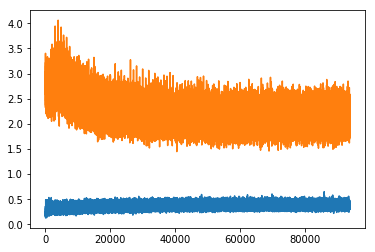

In [49]:
plt.plot(dll)
plt.plot(tll)

In [50]:
model_eval(mnistm_train_set, source_encoder)
model_eval(mnistm_train_set, target_encoder)

Loss: 11.99 | Accuracy: 15.52%
Loss: 5.293 | Accuracy: 46.31%


(5.293442, 0.46313334)

In [51]:
model_eval(mnistm_test_set, source_encoder)
model_eval(mnistm_test_set, target_encoder)

Loss: 11.96 | Accuracy: 16.03%
Loss: 5.19 | Accuracy: 47.21%


(5.1904664, 0.4721)